In [ ]:
rna_enhancers_rds = "10X_PBMC/05_erna_preprocess/filtered_erna_pbmc_granulocyte_sorted_10k.rds"
atac_counts_path = "10X_PBMC/ATAC/01_count_fragments/pbmc_granulocyte_sorted_10k_enhancer_counts.mtx"
atac_barcodes_path = "10X_PBMC/ATAC/01_count_fragments/pbmc_granulocyte_sorted_10k_barcodes.tsv"
atac_features_path = "10X_PBMC/ATAC/01_count_fragments/pbmc_granulocyte_sorted_10k_features.tsv"
enhancer_per_celltype_path = "10X_PBMC/enhancers/enhancer_per_cell_type/enhancer_per_cell_type_id.tsv"
binarize_threshold = 2


# eRNA count matrix analysis

In [49]:
library(magrittr)
library(dplyr)
library(stringi)
library(ggplot2)

In [4]:
setwd(here::here()) # set working directory to project root
getwd()

[1] "/sci/labs/yotamd/lab_share/avishai.wizel/Projects/eRNA"

In [5]:
rna_enhancers = readRDS(rna_enhancers_rds)

# ATAC counts

In [6]:
atac_counts <- Matrix::readMM(atac_counts_path) %>% as.matrix()

Warning message:
In asMethod(object) :
  sparse->dense coercion: allocating vector of size 15.7 GiB


In [7]:
atac_barcodes <- read.table(atac_barcodes_path)
atac_features <- read.table(atac_features_path)
rownames(atac_counts) <- atac_features$V1
colnames(atac_counts) <- atac_barcodes$V1 %>% gsub("-1$", "", .)
atac_counts[1:10, 1:10]
dim(atac_counts)

[1] 177340  11909

In [8]:
atac_counts = Matrix(atac_counts,sparse = TRUE)

# Set common enhancers and features

In [11]:
print(dim(rna_enhancers))
print(dim(atac_counts))

common_ernas = intersect(rownames(rna_enhancers), rownames(atac_counts))
print(length(common_ernas))
common_enhancers = intersect(colnames(rna_enhancers), colnames(atac_counts))
print(length(common_cells))

[1] 29683 11868
[1] 177340  11909
[1] 29683
[1] 11868


In [12]:
#set common rownames and colnames
rna_enhancers = rna_enhancers[common_ernas, common_cells]
atac_counts = atac_counts[common_ernas, common_cells]

In [13]:
# clear objects to save memory
rm(atac_barcodes, atac_features)
gc()

           used  (Mb) gc trigger    (Mb)   max used    (Mb)
Ncells  2657044 142.0    4982108   266.1    3548421   189.6
Vcells 21944005 167.5 6090754718 46468.8 6400579354 48832.6

In [14]:
class(rna_enhancers)
class(atac_counts)

[1] "dgCMatrix"
attr(,"package")
[1] "Matrix"

In [15]:
head(atac_counts)
head(rna_enhancers)
class(rna_enhancers)
class(atac_counts)
dim(rna_enhancers)
dim(atac_counts)

[1] 29683 11868

# Cell type specific enhancers filtering

In [27]:
# read enhancer per cell type files
library(stringi)
library(data.table)
enhancer_per_celltype_df= data.table::fread(enhancer_per_celltype_path, header = F, data.table = FALSE, sep = "\t")

In [31]:
enhancer_per_celltype = enhancer_per_celltype_df[,1]
names(enhancer_per_celltype) = enhancer_per_celltype_df[,2]
head(enhancer_per_celltype)

          CD8+ CD14+_monocyte           CD8+ CD14+_monocyte           CD8+ CD14+_monocyte 
  "ENSR1_9CZM"   "ENSR1_9CZM"   "ENSR1_8PZK"   "ENSR1_8PZK"   "ENSR1_8PZQ"   "ENSR1_8PZQ" 

In [67]:
cell_type_enhancers = unique(enhancer_per_celltype)
length(cell_type_enhancers)
cell_type_enhancers = intersect(cell_type_enhancers, common_ernas)
length(cell_type_enhancers)

[1] 5303

In [35]:
atac_counts = (atac_counts)[cell_type_enhancers, ]
rna_enhancers  = rna_enhancers[cell_type_enhancers, ]
dim(atac_counts)
dim(rna_enhancers)

[1]  5303 11868

In [36]:
library(Matrix)
original_rna_mat = Matrix(rna_enhancers,sparse = TRUE)
original_atac_mat = Matrix(atac_counts,sparse = TRUE)

# Spearman correlation

In [37]:
rna_enhancers = original_rna_mat %>% as.matrix()
atac_counts = original_atac_mat %>% as.matrix() 

In [ ]:
# remove all 0 cells
zero_cells = colSums(atac_counts) == 0 | colSums(rna_enhancers) == 0
atac_counts = atac_counts[, !zero_cells]
rna_enhancers = rna_enhancers[, !zero_cells]

# remove all 0 enhancers
zero_enhancers = rowSums(atac_counts) == 0 | rowSums(rna_enhancers) == 0
atac_counts = atac_counts[, !zero_enhancers]
rna_enhancers = rna_enhancers[, !zero_enhancers]

In [45]:
dim(atac_counts)
dim(rna_enhancers)
rna_enhancers = rna_enhancers %>% as.matrix()
atac_counts = atac_counts %>% as.matrix()
class(rna_enhancers)
class(atac_counts)

[1] "matrix" "array" 

In [46]:
# spearman per cell
spearman_per_cell <- mapply(function(x, y){cor(x, y,method = "spearman")}, as.data.frame(rna_enhancers), as.data.frame(atac_counts))


In [47]:
head(spearman_per_cell)

AAACAGCCAAGGAATC AAACAGCCAATCCCTT AAACAGCCAATGCGCT AAACAGCCACACTAAT AAACAGCCACCAACCG AAACAGCCAGGATAAC 
    0.0488460951     0.0587662892     0.0006403415    -0.0035428995    -0.0101202742    -0.0077779172 

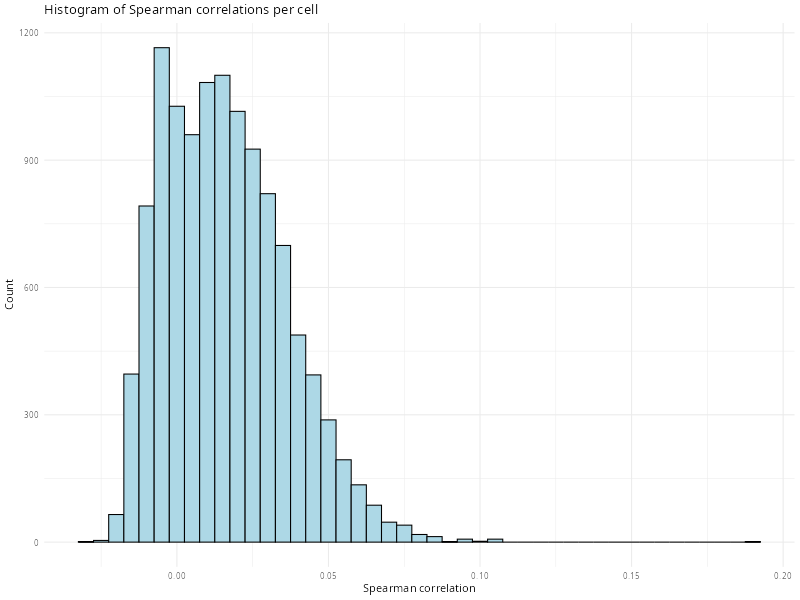

In [50]:
#histogram of spearman correlations with small binwidth
spearman_df = data.frame(spearman = spearman_per_cell)
p = ggplot(spearman_df, aes(x = spearman)) +
  geom_histogram(binwidth = 0.005, fill = "lightblue", color = "black") +
  labs(title = "Histogram of Spearman correlations per cell", x = "Spearman correlation", y = "Count") +
  theme_minimal()
p

In [ ]:
df = data.frame(
  eRNA = as.vector(rna_enhancers),
  ATAC = as.vector(atac_counts)
)

[1] 0

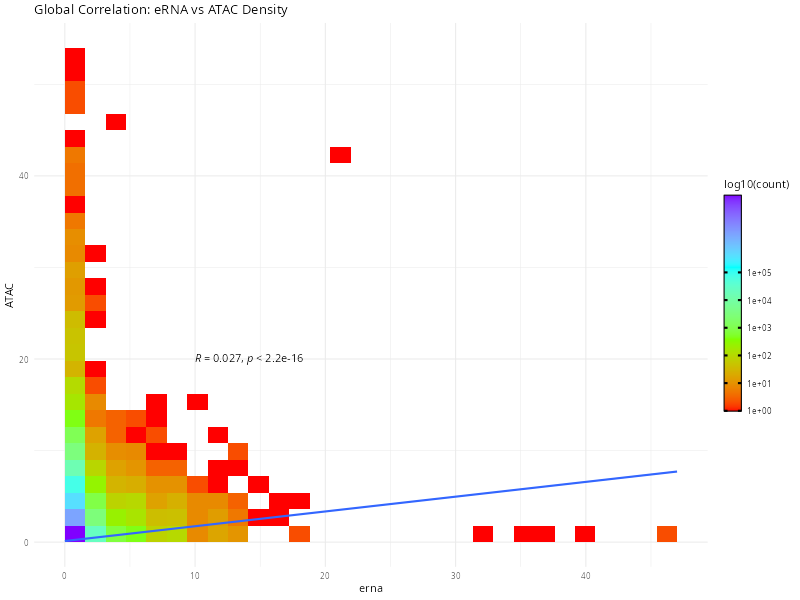

In [ ]:
library(ggpubr)
library(scales)
my_breaks <- c(1, 10, 100, 1000, 10000, 100000)
my_values <- rescale(log10(my_breaks), type = "q")

ggplot(df, aes(x = eRNA, y = ATAC)) +
  geom_bin2d(bins = 30) +
  scale_fill_gradientn(colors  = rainbow(4),values = my_values,
  breaks = my_breaks ,trans = "log10") +
  guides(fill = guide_colorbar(
    ticks.colour = "black",
    ticks.linewidth = 1,   
    frame.colour = "black",
    barheight = 15         
  ))+
  #geom_point(alpha = 0.3) +
  theme_minimal() +
  labs(title = "Global Correlation: eRNA vs ATAC Density",x = "erna", y= "ATAC")+
  geom_smooth(method = "lm", formula = y ~ x) +
  stat_cor(label.y = 20, label.x = 10)

There were 23 warnings (use warnings() to see them)
Warning messages:
1: Removed 23 rows containing non-finite outside the scale range (`stat_bin2d()`). 
2: Removed 1 row containing missing values or values outside the scale range (`geom_text()`). 


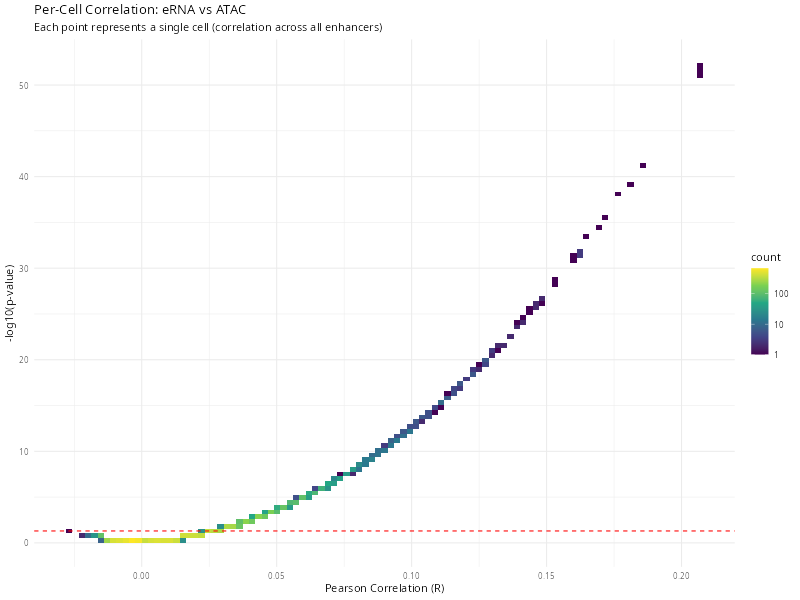

In [ ]:

# 1. Calculate R and P-value for each cell (column)
# Assumption: rna_enhancers and atac_counts are matrices where 
# Rows = Enhancers and Columns = Cells.
cell_results <- sapply(1:ncol(rna_enhancers), function(i) {
  
  # Run Pearson correlation test between eRNA and ATAC for cell 'i'
  # We use use = "complete.obs" to handle potential NA values
  res <- cor.test(rna_enhancers[, i], atac_counts[, i], method = "pearson")
  
  # Return a vector containing the correlation coefficient (R) and the p-value
  return(c(R = res$estimate, pval = res$p.value))
})

# 2. Reformat the results into a Data Frame
# t() transposes the matrix so that each row represents one cell
cell_df <- as.data.frame(t(cell_results))
colnames(cell_df) <- c("R", "pvalue")

# 3. Add a column for -log10(p-value) for the Y-axis
# We add a tiny offset (1e-300) to avoid log(0) calculation for very small p-values
cell_df <- cell_df %>%
  mutate(log10p = -log10(pvalue + 1e-300))

# 4. Generate the Scatterplot
ggplot(cell_df, aes(x = R, y = log10p)) +
  # Use semi-transparent points to visualize density (useful for 5K-10K cells)
  geom_bin2d(bins = 100) +
  scale_fill_viridis_c(trans = "log10")+
  # Add a horizontal dashed line for the significance threshold (p = 0.05)
  # -log10(0.05) is approximately 1.3
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "red") +
  
  # Add visual themes and labels
  theme_minimal() +
  labs(
    title = "Per-Cell Correlation: eRNA vs ATAC",
    subtitle = "Each point represents a single cell (correlation across all enhancers)",
    x = "Pearson Correlation (R)",
    y = "-log10(p-value)"
  ) +
  
  # Add a text label for the significance threshold
  annotate("text", x = min(cell_df$R), y = -log10(0.05), 
           label = "p = 0.05", color = "red", vjust = -1, hjust = 0)


There were 26 warnings (use warnings() to see them)
Warning messages:
1: Removed 26 rows containing non-finite outside the scale range (`stat_bin2d()`). 
2: Removed 1 row containing missing values or values outside the scale range (`geom_text()`). 


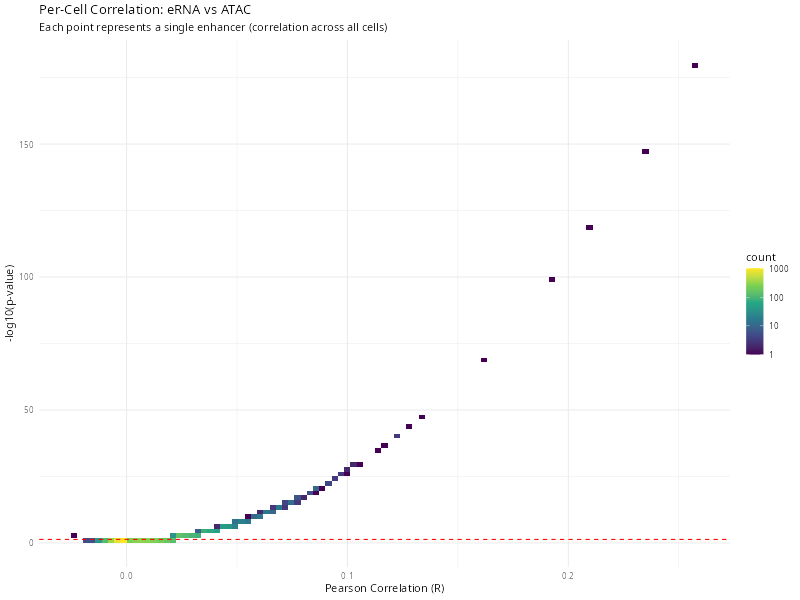

In [250]:

# 1. Calculate R and P-value for each cell (column)
cell_results <- sapply(1:nrow(rna_enhancers), function(i) {
  
  # Run Pearson correlation test between eRNA and ATAC for cell 'i'
  # We use use = "complete.obs" to handle potential NA values
  res <- cor.test(rna_enhancers[i, ], atac_counts[i, ], method = "pearson")
  
  # Return a vector containing the correlation coefficient (R) and the p-value
  return(c(R = res$estimate, pval = res$p.value))
})

# 2. Reformat the results into a Data Frame
# t() transposes the matrix so that each row represents one cell
cell_df <- as.data.frame(t(cell_results))
rownames(cell_df) <- rownames(rna_enhancers)
colnames(cell_df) <- c("R", "pvalue")

# 3. Add a column for -log10(p-value) for the Y-axis
# We add a tiny offset (1e-300) to avoid log(0) calculation for very small p-values
cell_df <- cell_df %>%
  mutate(log10p = -log10(pvalue + 1e-300))

# 4. Generate the Scatterplot
ggplot(cell_df, aes(x = R, y = log10p)) +
  # Use semi-transparent points to visualize density (useful for 5K-10K cells)
  geom_bin2d(bins = 100) +
  scale_fill_viridis_c(trans = "log10")+
  # Add a horizontal dashed line for the significance threshold (p = 0.05)
  # -log10(0.05) is approximately 1.3
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "red") +
  
  # Add visual themes and labels
  theme_minimal() +
  labs(
    title = "Per-Cell Correlation: eRNA vs ATAC",
    subtitle = "Each point represents a single enhancer (correlation across all cells)",
    x = "Pearson Correlation (R)",
    y = "-log10(p-value)"
  ) +
  
  # Add a text label for the significance threshold
  annotate("text", x = min(cell_df$R), y = -log10(0.05), 
           label = "p = 0.05", color = "red", vjust = -1, hjust = 0)


# Binarize

In [95]:
rna_enhancers = original_rna_mat %>% as.matrix()
atac_counts = original_atac_mat %>% as.matrix() 

In [76]:
# binarize the data
atac_counts[atac_counts<binarize_threshold] <- 0
atac_counts[atac_counts>=binarize_threshold] <- 1

rna_enhancers[rna_enhancers<binarize_threshold] <- 0
rna_enhancers[rna_enhancers>=binarize_threshold] <- 1


In [77]:
# remove all 0 cells
zero_cells = colSums(atac_counts) == 0 | colSums(rna_enhancers) == 0
atac_counts = atac_counts[, !zero_cells]
rna_enhancers = rna_enhancers[, !zero_cells]

# remove all 0 enhancers
zero_enhancers = rowSums(atac_counts) == 0 | rowSums(rna_enhancers) == 0
atac_counts = atac_counts[, !zero_enhancers]
rna_enhancers = rna_enhancers[, !zero_enhancers]

In [78]:
print(dim(atac_counts))
dim(rna_enhancers)

[1] 5303 4831


[1] 5303 4831

In [79]:
# Jaccard Index = TP / (TP + FP + FN)
calculate_jaccard <- function(v1, v2) {
    # Check for perfect length match (safety check)
    if (length(v1) != length(v2)) stop("Vectors must be of equal length.")
    
    # True Positives (TP): Both are 1
    TP <- sum(v1 == 1 & v2 == 1)
    
    # Union Size (TP + FP + FN): At least one is 1
    union_size <- sum(v1 == 1 | v2 == 1)
    # Handle the edge case where a cell has zero activity across all 11,909 enhancers
    if (union_size == 0) return(0)  
    return(TP / union_size)
}

In [80]:
phi_per_cell <- mapply(function(x, y){cor(x, y)}, as.data.frame(rna_enhancers), as.data.frame(atac_counts))


In [81]:

head(phi_per_cell)

AAACAGCCAATCCCTT AAACAGCCACCAACCG AAACAGCCAGTAGGTG AAACAGCCAGTTTACG AAACATGCAGCAAGTG AAACCAACACAATGCC 
    -0.004135877     -0.001783998     -0.007004594     -0.002884131      0.065395104     -0.004807090 

In [82]:
jaccard_per_cell = mapply(function(x, y){calculate_jaccard(x, y)}, as.data.frame(rna_enhancers), as.data.frame(atac_counts))

In [83]:
head(jaccard_per_cell)

AAACAGCCAATCCCTT AAACAGCCACCAACCG AAACAGCCAGTAGGTG AAACAGCCAGTTTACG AAACATGCAGCAAGTG AAACCAACACAATGCC 
     0.000000000      0.000000000      0.000000000      0.000000000      0.004464286      0.000000000 

In [84]:
results_df <- data.frame(
    Phi = phi_per_cell,
    Jaccard = jaccard_per_cell
)

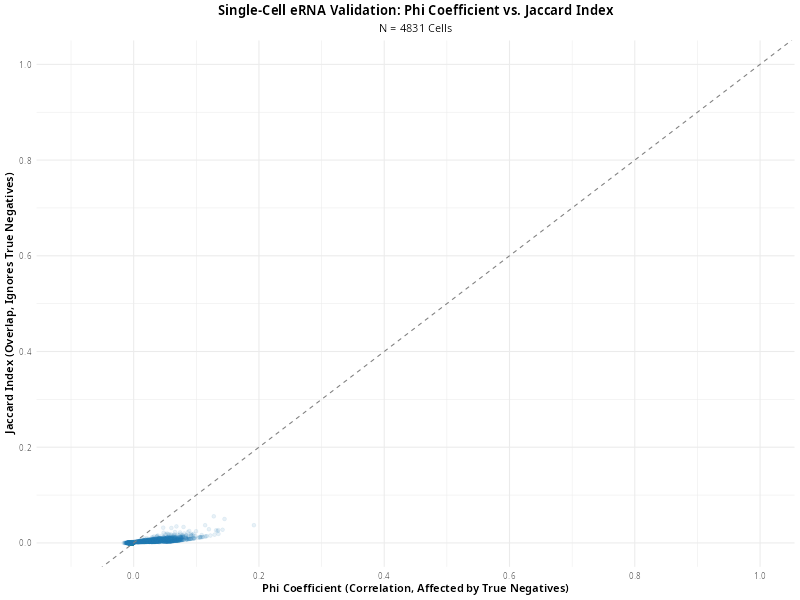

In [85]:
ggplot(results_df, aes(x = Phi, y = Jaccard)) +
    
    # 1. Scatter points with transparency (crucial for large datasets)
    # Using geom_point with high alpha to show point density.
    geom_point(alpha = 0.1, size = 1.5, color = "#1f78b4") + 
    

    
    # 3. Add the identity line (y = x) for comparison
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "gray50") +
    
    # 4. Define axis limits and labels
    scale_x_continuous(limits = c(-0.1, 1), breaks = seq(0, 1, 0.2)) + 
    scale_y_continuous(limits = c(0, 1), breaks = seq(0, 1, 0.2)) + 
    
    labs(
        title = "Single-Cell eRNA Validation: Phi Coefficient vs. Jaccard Index",
        subtitle = paste0("N = ", nrow(results_df), " Cells"),
        x = "Phi Coefficient (Correlation, Affected by True Negatives)",
        y = "Jaccard Index (Overlap, Ignores True Negatives)"
    ) +
    
    # 5. Apply a clean theme
    theme_minimal() +
    theme(
        plot.title = element_text(face = "bold", hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5),
        axis.title = element_text(face = "bold")
    )

In [86]:

contingency_table <- table(c(as.matrix(atac_counts)),c(as.matrix(rna_enhancers)))
contingency_table

   
           0        1
  0 24392498    12799
  1  1210795     2701

In [87]:
test <- fisher.test(contingency_table)
test


	Fisher's Exact Test for Count Data

data:  contingency_table
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 4.077276 4.432464
sample estimates:
odds ratio 
  4.251466 


In [88]:
# histogram of fisher per cell p-values with ggplot2
library(ggplot2)
fisher_per_cell_test = function(x, y){
    fisher.test(table(x, y))$p.value
}
fisher_per_cell = mapply(fisher_per_cell_test, as.data.frame(rna_enhancers), as.data.frame(atac_counts))



[1] "Number of cells with significant association (FDR < 0.05): 18 out of 4831"


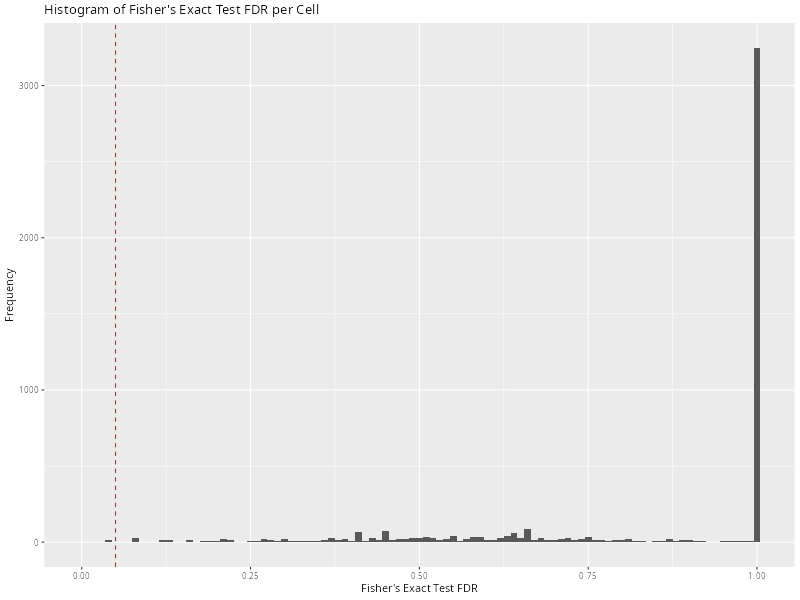

In [89]:
# create a data frame for plotting
fisher_df = data.frame(fdr = p.adjust(fisher_per_cell,method = "fdr"))

# plot the histogram
ggplot(fisher_df, aes(x = fdr)) +
    geom_histogram(binwidth = 0.01) +
    xlab("Fisher's Exact Test FDR") +
    ylab("Frequency") +
    # add line at 0.05 significance level
    geom_vline(xintercept = 0.05, color = "#8a3c3c", linetype = "dashed") +
    ggtitle("Histogram of Fisher's Exact Test FDR per Cell")

#count cells with significant FDR < 0.05
significant_cells = sum(fisher_df$fdr < 0.05)
print(paste0("Number of cells with significant association (FDR < 0.05): ", significant_cells, " out of ", length(fisher_per_cell)))

In [90]:
# histogram of fisher per enhancer p-values with ggplot2
library(ggplot2)
fisher_per_enhancer_test = function(x, y){
    tryCatch(fisher.test(table(x, y))$p.value, error = function(e) NA)
}
fisher_per_enhancer = mapply(fisher_per_enhancer_test, as.data.frame(t(rna_enhancers)), as.data.frame(t(atac_counts)))



[1] "Number of enhancers with significant association (FDR < 0.05): 8 out of 2098"


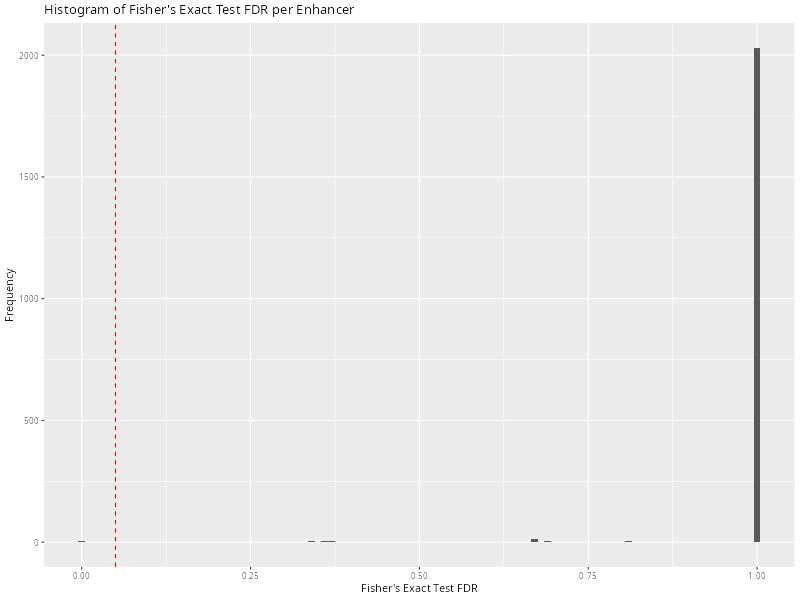

In [91]:
fisher_per_enhancer = na.omit(fisher_per_enhancer)
# create a data frame for plotting
fisher_df = data.frame(fdr = p.adjust(fisher_per_enhancer,method = "fdr"))

# plot the histogram
ggplot(fisher_df, aes(x = fdr)) +
    geom_histogram(binwidth = 0.01) +
    xlab("Fisher's Exact Test FDR") +
    ylab("Frequency") +
    # add line at 0.05 significance level
    geom_vline(xintercept = 0.05, color = "red", linetype = "dashed") +
    ggtitle("Histogram of Fisher's Exact Test FDR per Enhancer")

#count enhancers with significant FDR < 0.05
significant_enhancers = sum(fisher_df$fdr < 0.05)
print(paste0("Number of enhancers with significant association (FDR < 0.05): ", significant_enhancers, " out of ", length(fisher_per_enhancer)))